In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.externals import joblib
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from utils import plot_confusion_matrix

In [2]:
filename = '/Users/junginpark/data/SEER_1973_2015_TEXTDATA/incidence/csv/COLRECT_converted.pickle'

df = pd.read_pickle(filename)

df.head()

,PUBCSNUM,AGE_DX,YR_BRTH,MDXRECMP,YEAR_DX,REC_NO,SRV_TIME_MON,MALIGCOUNT,BENBORDCOUNT,REG__1501,...,INTPRIM__1,INTPRIM__9,CSSCHEMA__25,CSSCHEMA__26,CSSCHEMA__36,SRV_TIME_MON_FLAG__0,SRV_TIME_MON_FLAG__1,SRV_TIME_MON_FLAG__2,SRV_TIME_MON_FLAG__3,SRV_TIME_MON_FLAG__8
0,7000005,83,1892,10,1975,1,0,2,0,0,...,1,0,1,0,0,0,1,0,0,0
1,7000012,80,1896,1,1977,1,63,2,0,0,...,1,0,1,0,0,0,1,0,0,0
2,7000033,78,1908,12,1986,1,181,2,0,0,...,0,1,1,0,0,0,1,0,0,0
3,7000035,75,1914,12,1989,1,26,2,0,0,...,1,0,1,0,0,0,1,0,0,0
4,7000038,70,1903,9,1973,1,50,2,0,0,...,1,0,0,1,0,0,1,0,0,0


In [3]:
# Filter

df_filtered = df

if 'MAR_STAT__9' in df_filtered.columns:
    df_filtered = df_filtered.loc[df_filtered['MAR_STAT__9'] == 0]
if 'RACE1V__99' in df_filtered.columns:
    df_filtered = df_filtered.loc[df_filtered['RACE1V__99'] == 0]
if 'AGE_DX' in df_filtered.columns:
    df_filtered = df_filtered.loc[df_filtered['AGE_DX'] != 999]
if 'SEQ_NUM__99' in df_filtered.columns:
    df_filtered = df_filtered.loc[df_filtered['SEQ_NUM__99'] == 0]
if 'SEQ_NUM__88' in df_filtered.columns:
    df_filtered = df_filtered.loc[df_filtered['SEQ_NUM__88'] == 0]
if 'LATERAL__9' in df_filtered.columns:
    df_filtered = df_filtered.loc[df_filtered['LATERAL__9'] == 0]
if 'GRADE__9' in df_filtered.columns:
    df_filtered = df_filtered.loc[df_filtered['GRADE__9'] == 0]
if 'DX_CONF__9' in df_filtered.columns:
    df_filtered = df_filtered.loc[df_filtered['DX_CONF__9'] == 0]
if 'NO_SURG__0' in df_filtered.columns:
    df_filtered = df_filtered.loc[df_filtered['NO_SURG__0'] == 1]
if 'AGE_1REC__99' in df_filtered.columns:
    df_filtered = df_filtered.loc[df_filtered['AGE_1REC__99'] == 0]
if 'RAC_RECA__9' in df_filtered.columns:
    df_filtered = df_filtered.loc[df_filtered['RAC_RECA__9'] == 0]
if 'RAC_RECY__9' in df_filtered.columns:
    df_filtered = df_filtered.loc[df_filtered['RAC_RECY__9'] == 0]
if 'HST_STGA__9' in df_filtered.columns:
    df_filtered = df_filtered.loc[df_filtered['HST_STGA__9'] == 0]
if 'SRV_TIME_MON' in df_filtered.columns:
    df_filtered = df_filtered.loc[df_filtered['SRV_TIME_MON'] != 9999]
if 'MALIGCOUNT' in df_filtered.columns:
    df_filtered = df_filtered.loc[df_filtered['MALIGCOUNT'] != 99]
if 'BENBORDCOUNT' in df_filtered.columns:
    df_filtered = df_filtered.loc[df_filtered['BENBORDCOUNT'] != 99]

to_exclude = ['MAR_STAT__9', 'RACE1V__99', 'YR_BRTH', 'SEQ_NUM__99', 'SEQ_NUM__88', 
              'LATERAL__9', 'GRADE__9', 'DX_CONF__9', 'AGE_1REC__99', 
              'ICCC3WHO', 'ICCC3XWHO', 'RAC_RECA__9', 'RAC_RECY__9', 'HST_STGA__9',
              'SRV_TIME_MON_FLAG__0', 'SRV_TIME_MON_FLAG__1', 'SRV_TIME_MON_FLAG__2',
              'SRV_TIME_MON_FLAG__3', 'SRV_TIME_MON_FLAG__8'] + ['NO_SURG__' + str(x) for x in range(10)]
to_exclude = list(set(df_filtered.columns).intersection(set(to_exclude)))
df_filtered = df_filtered.drop(columns=to_exclude, axis=1)

df_filtered.shape

(646538, 1486)

In [4]:
filtered_filename = '/Users/junginpark/data/SEER_1973_2015_TEXTDATA/incidence/csv/COLRECT_filtered.pickle'

df_filtered.to_pickle(filtered_filename)

In [24]:
# Prepare training

x_df = df_filtered.drop(columns=['PUBCSNUM', 'SRV_TIME_MON'])
X = x_df.values.astype(np.float32)
y_cont = df_filtered.SRV_TIME_MON.values.astype(np.float32)
y = np.where(y_cont > 60, 1, 0)

print(f'Feature shape: {X.shape}')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

Feature shape: (646538, 1484)


In [7]:
# Feature selection (Step 1. RF training)

print('Start training random forest...')
model_for_fs = RandomForestClassifier(n_jobs=8, random_state=42)
model_for_fs.fit(X_train, y_train)

Start training random forest...


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=8,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [28]:
# Feature selection (Step 2. create feature selector)

feature_selector = SelectFromModel(model_for_fs, prefit=True)
feature_selected_column_names = x_df.columns[feature_selector.get_support()].values

with open('feature_selected_column_info.txt', 'w') as f:
    f.write(' '.join(feature_selected_column_names))
    
with open('feature_selected_column_info_simple.txt', 'w') as f:
    simple = []
    for name in feature_selected_column_names:
        simple.append(name.split('_')[0])
    simple = list(set(simple))
    f.write(' '.join(simple))

In [29]:
# Feature selection (Step 2. transform Xs)

X_train_fs = feature_selector.transform(X_train)
X_test_fs = feature_selector.transform(X_test)

In [30]:
# Logistic Regression

print('Start training logistic regression...')
model_lr = LogisticRegression()
model_lr.fit(X_train_fs, y_train)

print('Saving logistic regression model...')
joblib.dump(model_lr, 'model_lr.pickle')

Start training logistic regression...
Saving logistic regression model...


['model_lr.pickle']

Training set evaluation
             precision    recall  f1-score   support

    <= 5yrs       0.78      0.72      0.75    256123
     > 5yrs       0.67      0.73      0.70    196453

avg / total       0.73      0.72      0.72    452576

Test set evaluation
             precision    recall  f1-score   support

    <= 5yrs       0.78      0.72      0.75    109735
     > 5yrs       0.67      0.73      0.70     84227

avg / total       0.73      0.73      0.73    193962

Confusion matrix, without normalization


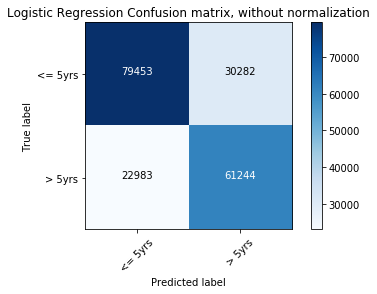

Normalized confusion matrix


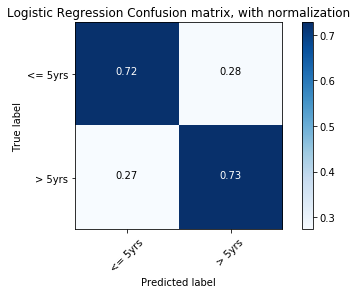

In [31]:
target_names = ['<= 5yrs', '> 5yrs']

print('Training set evaluation')
y_train_pred = model_lr.predict(X_train_fs)
print(classification_report(y_train, y_train_pred, target_names=target_names))

print('Test set evaluation')
y_test_pred = model_lr.predict(X_test_fs)
print(classification_report(y_test, y_test_pred, target_names=target_names))

cnf_matrix = confusion_matrix(y_test, y_test_pred)
plot_confusion_matrix(cnf_matrix, classes=target_names, normalize=False,
                      title='Logistic Regression Confusion matrix, without normalization')
plt.show()
plot_confusion_matrix(cnf_matrix, classes=target_names, normalize=True,
                      title='Logistic Regression Confusion matrix, with normalization')
plt.show()

In [32]:
# Random Forest

print('Start training random forest...')
model_rf = RandomForestClassifier(n_jobs=8, random_state=42)
model_rf.fit(X_train_fs, y_train)

print('Saving random forest model...')
joblib.dump(model_rf, 'model_rf.pickle')

Start training random forest...
Saving random forest model...


['model_rf.pickle']

Training set evaluation
             precision    recall  f1-score   support

    <= 5yrs       0.99      1.00      0.99    256123
     > 5yrs       1.00      0.98      0.99    196453

avg / total       0.99      0.99      0.99    452576

Test set evaluation
             precision    recall  f1-score   support

    <= 5yrs       0.84      0.89      0.86    109735
     > 5yrs       0.85      0.78      0.81     84227

avg / total       0.84      0.84      0.84    193962

Confusion matrix, without normalization


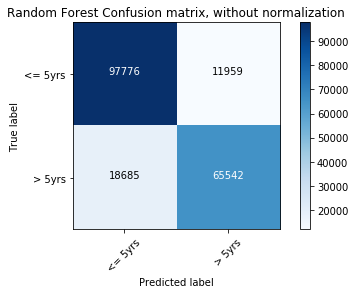

Normalized confusion matrix


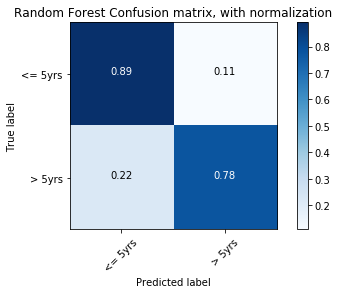

In [33]:
print('Training set evaluation')
y_train_pred = model_rf.predict(X_train_fs)
print(classification_report(y_train, y_train_pred, target_names=target_names))

print('Test set evaluation')
y_test_pred = model_rf.predict(X_test_fs)
print(classification_report(y_test, y_test_pred, target_names=target_names))

cnf_matrix = confusion_matrix(y_test, y_test_pred)
plot_confusion_matrix(cnf_matrix, classes=target_names, normalize=False,
                      title='Random Forest Confusion matrix, without normalization')
plt.show()
plot_confusion_matrix(cnf_matrix, classes=target_names, normalize=True,
                      title='Random Forest Confusion matrix, with normalization')
plt.show()

In [34]:
filtered_column_names = df_filtered.columns.tolist()
filtered_column_names.remove('PUBCSNUM')
filtered_column_names.remove('SRV_TIME_MON')

with open('column_info.txt', 'w') as f:
    f.write(' '.join(filtered_column_names))

In [ ]:
filtered_filename = '/Users/junginpark/data/SEER_1973_2015_TEXTDATA/incidence/csv/COLRECT_filtered.csv'

df_filtered.to_csv(filtered_filename)